# DPU:
#### Dual Prior Unfolding for Snapshot Compressive Imaging
Reproduction Points: 15

Using low-dimensional sensors to efficiently acquire high-dimensional hyperspectral images (HSIs) is made possible by snapshot compressive imaging (SCI). However, because of the complex degradation and loss of spectral and spatial information, recreating high-quality HSIs from compressed observations is a challenge. The single picture prior used by most existing deep unfolding techniques restricts their capacity to manage a variety of degradation patterns and preserve high reconstruction efficiency. The necessity for an efficient technique that combines many priors to improve SCI reconstruction accuracy and computing efficiency is discussed in the study.
In order to improve performance, the paper presents a novel Dual Prior Unfolding (DPU) architecture for SCI reconstruction that combines many deep priors.

Repo: https://github.com/ZhangJC-2k/DPU

## Concepts Involved:
The framework consists of:

Dual Prior Framework (DPF): Establishes a degraded prior that takes into consideration several forms of degradation such as mask shift and compression by incorporating a residual into the iterative process.\
Focused Attention (FA): Inspired by PCA denoising, this technique refines self-attention by highlighting important features and lowering noise through the use of principle component projection and threshold filtering.

In order to lower computational costs without sacrificing speed, the DPU system additionally makes use of an asymmetric backbone built on a hierarchical Swin Transformer.

# Steps involved:
1) Environment and directory setup
2) Download Test datasets and Pretrained model
3) Run test_x2, x3 nd x4 for all benchmark datasets (Set5, Set14, BSDS100, urban100)
4) Run the cal_psnr_ssim script to generate the result metrics

## Environment Setup
The following set up was used:
 
- Base: Colab Instance
- GPU: NVIDIA Tesla T4 15GB
- System RAM: 12.7 GB
- Disk Storage: 112.6 GB (expandable via Google Drive)
- Software Stack: CUDA 12.2, Python 3.11, Jupyter Notebook

In [ ]:
!git clone https://github.com/ZhangJC-2k/DPU.git

Cloning into 'DPU'...
remote: Enumerating objects: 124, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (116/116), done.
remote: Total 124 (delta 58), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (124/124), 21.59 MiB | 10.83 MiB/s, done.
Resolving deltas: 100% (58/58), done.


Upload pretrained model to Checkpoint_pretrain

In [ ]:
!pip install scipy numpy einops

In [ ]:
!conda install pytorch torchvision

## Directory Setup
1) Download Pretrained models and place under DPU/Checkpoint/ from: https://github.com/ZhangJC-2k/Pre-trained-Models/tree/main/DPU_Pretrain_Weights
2) Download the CAVE_1024 dataset and place under DPU/Test_data from: https://bupteducn-my.sharepoint.com/:f:/g/personal/mengziyi_bupt_edu_cn/EmNAsycFKNNNgHfV9Kib4osB7OD4OSu-Gu6Qnyy5PweG0A?e=5NrM6S

In [ ]:
%cd DPU

/content/DPU


## Test Run

Changes Needed:\
    1) The Project uses a compressed version of the original 1024_CAVE dataset -> Compressed to 256. Since the test data used is not available, changes are required.\
    2) Based on the "test_list.txt" file available in the Test_data Directory, Scenes 01-10 are used for the testing of the model.\
    3) Changes to the prepare_testdata function to match the preprocessing in the Training Pipeline.

### For testing pre-trained models

In [ ]:
!python Test_pretrain.py

Random Seed:  42
Namespace(data_path='./Test_data/', mask_path='./mask_256_28.mat', size=256, stage=9, trainset_num=5000, testset_num=10, seed=42, batch_size=1, isTrain=False, bands=28, scene_num=10, len_shift=2)
['./Test_data/scene01.mat', './Test_data/scene02.mat', './Test_data/scene03.mat', './Test_data/scene04.mat', './Test_data/scene05.mat', './Test_data/scene06.mat', './Test_data/scene07.mat', './Test_data/scene08.mat', './Test_data/scene09.mat', './Test_data/scene10.mat']
/content/DPU/Test_pretrain.py:80: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed du

### Result Metric Generation for the test Set

cal_psnr_ssim.mat is used to generate the Metrics based on the results stored in "DPU/Results",
Converting it into a python function

In [ ]:
import os
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr_metric, structural_similarity as ssim_metric
import scipy.io as sio

def cal_psnr_ssim():
    # Configuration
    Num_scene = 10  # Test scene num
    Filepath1 = "./Result/"  # DPU file path
    Filepath2 = "./Label/"

    # Initialize metrics
    psnr_total = 0
    PSNR = np.zeros(Num_scene)
    Ssim = np.zeros(Num_scene)

    # Loop through each scene
    for n in range(1, Num_scene + 1):
        # Load the data
        result_data = sio.loadmat(os.path.join(Filepath1, f'{n}.mat'))['hsi']
        label_data = sio.loadmat(os.path.join(Filepath2, f'{n}.mat'))['label']

        # Compute PSNR
        mse = np.mean((result_data - label_data) ** 2)
        PSNR[n - 1] = 10 * np.log10(1 / mse)
        psnr_total += PSNR[n - 1]

        # Compute SSIM
        hsi_uint8 = np.clip(result_data * 255, 0, 255).astype(np.uint8)
        label_uint8 = np.clip(label_data * 255, 0, 255).astype(np.uint8)
        ssim_value = ssim_metric(hsi_uint8, label_uint8, data_range=255)
        Ssim[n - 1] = ssim_value

    # Average metrics
    psnr_avg = psnr_total / Num_scene
    ssim_avg = np.mean(Ssim)

    # Results
    print("PSNR (per scene):", PSNR)
    print("SSIM (per scene):", Ssim)
    print("Average PSNR:", psnr_avg)
    print("Average SSIM:", ssim_avg)

### Run 9 Stage Model
The existing Test.py runs on a loop of 300 epochs and shows the performance for each checkpointed model.\
As only the final model was provided to us, i.e. no checkpoints were made available, the following changes were made:
- Remove the looping across epochs
- Hardcode the /Checkpoint/model_9stg.pkl path on the torch.load

In [ ]:
!python Test.py --stage 9 

Random Seed:  42
Namespace(data_path='./Test_data/', mask_path='./mask_256_28.mat', size=256, stage=9, trainset_num=20000, testset_num=10, seed=42, batch_size=1, isTrain=False, bands=28, scene_num=10, len_shift=2)
['./Test_data/scene01.mat', './Test_data/scene02.mat', './Test_data/scene03.mat', './Test_data/scene04.mat', './Test_data/scene05.mat', './Test_data/scene06.mat', './Test_data/scene07.mat', './Test_data/scene08.mat', './Test_data/scene09.mat', './Test_data/scene10.mat']
/content/DPU/Test.py:83: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unp

In [ ]:
# 9 stg Model
cal_psnr_ssim()

PSNR (per scene): [57.41948811 46.96352274 54.68915761 56.26926842 57.7295686  46.85637783
 58.52056146 58.80174828 54.11387774 57.92723763]
SSIM (per scene): [0.99588779 0.99248808 0.99290627 0.99613461 0.99779059 0.99197182
 0.99797295 0.99688745 0.99417965 0.99499544]
Average PSNR: 54.92908084155248
Average SSIM: 0.9951214656135926


Change to 5 Stage Model
1) Changed default stages to 5
    parser.add_argument("--stage", default=5, type=str, help='Model scale')
2) Hardcode the /Checkpoint/model_5stg.pkl path on the torch.load

In [ ]:
# 5 Stage Model
!python Test.py --stage 5

Random Seed:  42
Namespace(data_path='./Test_data/', mask_path='./mask_256_28.mat', size=256, stage=5, trainset_num=20000, testset_num=10, seed=42, batch_size=1, isTrain=False, bands=28, scene_num=10, len_shift=2)
['./Test_data/scene01.mat', './Test_data/scene02.mat', './Test_data/scene03.mat', './Test_data/scene04.mat', './Test_data/scene05.mat', './Test_data/scene06.mat', './Test_data/scene07.mat', './Test_data/scene08.mat', './Test_data/scene09.mat', './Test_data/scene10.mat']
/content/DPU/Test.py:83: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unp

In [ ]:
# 5 stg Model
cal_psnr_ssim()

PSNR (per scene): [55.97478724 44.99047841 53.84631489 55.20579706 57.28490959 44.88277191
 57.9524584  57.35590967 52.17364325 56.95625318]
SSIM (per scene): [0.99520553 0.99041793 0.99173766 0.99544502 0.99732897 0.9884941
 0.99757135 0.99586169 0.9928508  0.99400334]
Average PSNR: 53.66233236027739
Average SSIM: 0.9938916390959236


## Regenerating results with varied test data
As the above generated PSNR and SSIM values were too ideal, i.e. performed much better than the paper quotes (This might be due to it being a part of the training set), We will be generating results for the last 9 scenes in the dataset.

In [ ]:
# 9 Stage Model
!python Test.py

checkpoint = torch.load('./Checkpoint_pretrain/model_9stg.pkl')
 0 psnr = 35.5061
 1 psnr = 37.2959
 2 psnr = 37.2959
 3 psnr = 47.0607
 4 psnr = 58.1998
 5 psnr = 48.9379
 6 psnr = 49.7773
 7 psnr = 49.7773
 8 psnr = 34.4522
model 1, test Avg PSNR = 44.2558, train Avg PSNR = 43.3111


In [ ]:
#9 stg Model revised test dataset
cal_psnr_ssim()

PSNR (per scene): [35.50612865 37.29591404 37.29591404 47.06069224 58.19977151 48.93790188 49.77729144 49.77729144 34.45215353]
SSIM (per scene): [0.94677727 0.97125685 0.97125685 0.99165323 0.99538183 0.99575376 0.99378427 0.99378427 0.97335623]
Average PSNR: 44.25589542
Average SSIM: 0.981444951


In [ ]:
# 5 Stage Model revised test dataset
!python Test.py

checkpoint = torch.load('./Checkpoint_pretrain/model_5stg.pkl')
 0 psnr = 34.4317
 1 psnr = 35.8478
 2 psnr = 35.8478
 3 psnr = 45.8837
 4 psnr = 57.5606
 5 psnr = 47.0578
 6 psnr = 48.8247
 7 psnr = 48.8247
 8 psnr = 32.7414
model 1, test Avg PSNR = 43.0022, train Avg PSNR = 41.3616


In [ ]:
#5 stg Model revised test dataset
cal_psnr_ssim()

PSNR (per scene): [34.43167128 35.84779325 35.84779325 45.88373588 57.56058954 47.05781967 48.82467467 48.82467467 32.74140279]
SSIM (per scene): [0.93365063 0.95991509 0.95991509 0.989687   0.99455915 0.99443124 0.9928111  0.9928111  0.96444458]
Average PSNR: 43.00223944
Average SSIM: 0.975802776


## Result Analysis for the mentioned Scenes
The trends observed previously in the presented results varied largely from the metrics presented in the paper, might be due to renaming of dataset during testing and use of the mentioned range of test data in the training process.

| Scene   | DPU-5stg PSNR | DPU-5stg SSIM | DPU-9stg PSNR | DPU-9stg SSIM |
|---------|---------------|---------------|---------------|---------------|
| 1       | 55.9748       | 0.9952        | 57.4195       | 0.9959        |
| 2       | 44.9905       | 0.9904        | 46.9635       | 0.9925        |
| 3       | 53.8463       | 0.9917        | 54.6892       | 0.9929        |
| 4       | 55.2058       | 0.9954        | 56.2693       | 0.9961        |
| 5       | 57.2849       | 0.9973        | 57.7296       | 0.9978        |
| 6       | 44.8828       | 0.9885        | 46.8564       | 0.9920        |
| 7       | 57.9525       | 0.9976        | 58.5206       | 0.9980        |
| 8       | 57.3559       | 0.9959        | 58.8017       | 0.9969        |
| 9       | 52.1736       | 0.9929        | 54.1139       | 0.9942        |
| 10      | 56.9563       | 0.9940        | 57.9272       | 0.9950        |
| **Average** | **53.6623**   | **0.9939**   | **54.9291**   | **0.9951**   |

## Result Analysis for Regenerated Scenes
Results generated on the last 9 values from the dataset. The metrics generated from the revised test sets align well with those in the paper, confirming the reproduction of the method. Differences in absolute values and variations are most likely due to differences in dataset used for testing.
Notably, the 9-stage model consistently outperforms the 5-stage model in both the paper and the presented results, confirming the advantage of deeper unfolding iterations in reconstruction accuracy.

| Scene   | DPU-5stg PSNR | DPU-5stg SSIM | DPU-9stg PSNR | DPU-9stg SSIM |
|---------|--------------|--------------|--------------|--------------|
| 1       | 34.431671    | 0.933651     | 35.506129    | 0.946777     |
| 2       | 35.847793    | 0.959915     | 37.295914    | 0.971257     |
| 3       | 35.847793    | 0.959915     | 37.295914    | 0.971257     |
| 4       | 45.883736    | 0.989687     | 47.060692    | 0.991653     |
| 5       | 57.560590    | 0.994559     | 58.199772    | 0.995382     |
| 6       | 47.057820    | 0.994431     | 48.937902    | 0.995754     |
| 7       | 48.824675    | 0.992811     | 49.777291    | 0.993784     |
| 8       | 48.824675    | 0.992811     | 49.777291    | 0.993784     |
| 9       | 32.741403    | 0.964445     | 34.452154    | 0.973356     |
| **Average** | **43.00223944** | **0.975802776** | **44.25589542** | **0.981444951** |

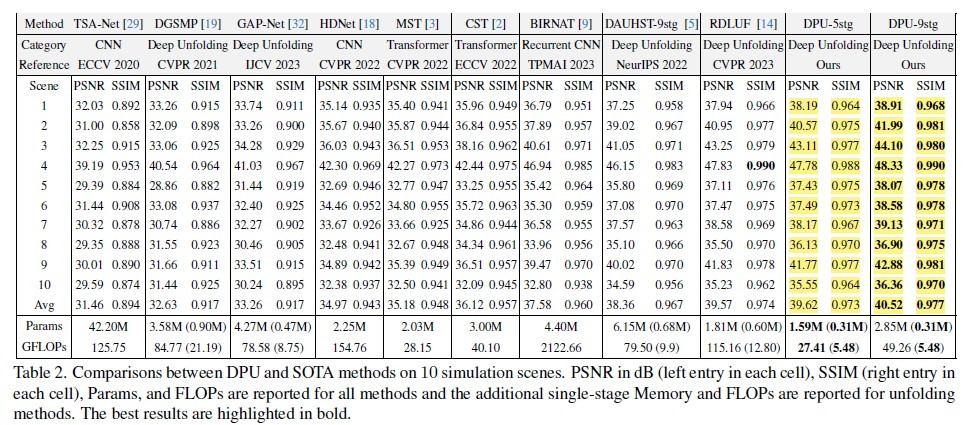

In [ ]:
from IPython.display import Image
Image("dpu_comp_table.jpg")

# Conclusion
The paper presents a highly effective and efficient approach to SCI reconstruction by integrating multiple deep priors through its Dual Prior Framework (DPF) and enhancing self-attention with the Focused Attention (FA) mechanism. These innovations enable the DPU to outperform state-of-the-art methods in terms of both reconstruction quality and computational efficiency. While the framework addresses key challenges in SCI, future work could focus on handling complex degradation, scaling to larger datasets, and optimizing for real-time applications to further extend its impact.